# Import Libraries

In [23]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import os
import glob
import math
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

# Functions

In [2]:
def canny_edge_detection(frame): 
    # Convert the frame to grayscale for edge detection 
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) 
        
    # Apply Gaussian blur to reduce noise and smoothen edges 
    # blurred = cv2.GaussianBlur(src=gray, ksize=(3, 5), sigmaX=0.5)  #CHANGE gray ---> blurred
    blurred = cv2.blur(gray,(3,3))

    # Perform Canny edge detection 
    edges = cv2.Canny(blurred, 70, 135)
      
    return edges,blurred

def get_contours(image,edges):

    # # define a (3, 3) structuring element
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # # apply the dilation operation to the edged image
    # dilate = cv2.dilate(edges, kernel, iterations=1) #CHANGE edge --> dilate

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours=sorted(contours, key=cv2.contourArea, reverse= True)
    
    image_copy = image.copy()
    
    # draw the contours on a copy of the original image
    cv2.drawContours(image_copy, sorted_contours, -1, (0, 255, 0), 2) 
    # print(len(contours), "object was found in this image.")

    return image_copy,contours

def crop(image,contours):
    c = max(contours, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    # cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0), 1)

    img_copy = image.copy()
    cropped_img=img_copy[y:y+h, x:x+w]

    return cropped_img

# Importing Data

In [6]:
mask_tongue_files = glob.glob("../../../Field Data/Individual Anatomy/Galaxy M34/Tongue_files/tongue_segmasks/SegmentationClass/*.png")
tongue_path = "../../../Field Data/Individual Anatomy/Galaxy M34/Tongue_files/Images_tongue\\"

# Trying on single sample

In [7]:
mask_path = mask_tongue_files[111]
name = mask_path.split("\\")[-1].split(".")[0] + ".jpg"

In [9]:
mask_bgr = cv2.imread(mask_path)
img_bgr = cv2.imread(tongue_path + name)
mask = cv2.cvtColor(mask_bgr,cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)

In [10]:
roi = cv2.bitwise_and(img, img, mask = mask)

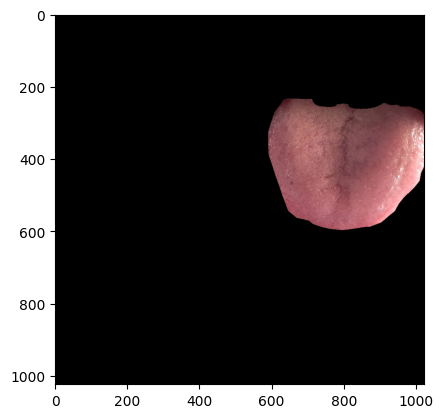

In [11]:
plt.imshow(roi)

In [12]:
img = roi
edges, blurred = canny_edge_detection(img)
img_copy,contours = get_contours(img,edges)
cropped_img = crop(img,contours) 

Text(0.5, 1.0, 'Cropped Image')

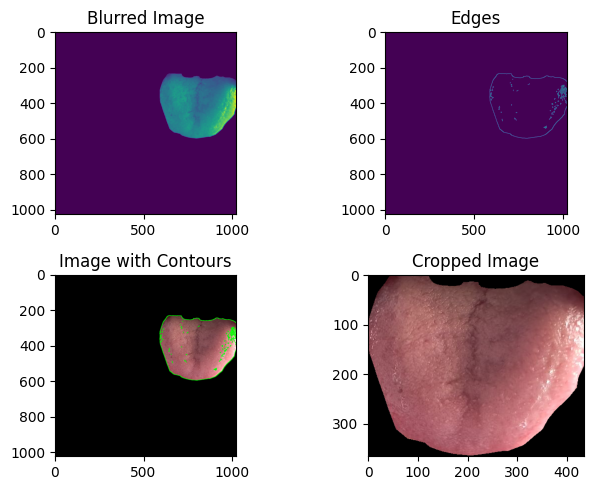

In [13]:
# create figure
fig = plt.figure(figsize=(7, 5))

# setting values to rows and column variables 
rows = 2
columns = 2

# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1)

# showing image 
plt.tight_layout()
plt.imshow(blurred) 
# plt.axis('off') 
plt.title(f"Blurred Image")

# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2)

# showing image
plt.tight_layout() 
plt.imshow(edges) 
# plt.axis('off') 
plt.title(f"Edges")

# Adds a subplot at the 3rd position 
fig.add_subplot(rows, columns, 3)

# showing image
plt.tight_layout() 
plt.imshow(img_copy) 
# plt.axis('off') 
plt.title(f"Image with Contours")

# Adds a subplot at the 4th position 
fig.add_subplot(rows, columns, 4)

# showing image
plt.tight_layout() 
plt.imshow(cropped_img) 
# plt.axis('off') 
plt.title(f"Cropped Image")

# Trying on all images

In [14]:
tongue_truth = pd.read_csv("../annotations_tongue.csv")
tongue_truth.head(5)

Annotated_Data  Avaiable ID  Hb Value  Unnamed: 3  Unnamed: 4  \
0  1709617694248.jpg    202403051      11.5         NaN         NaN   
1  1709617844626.jpg    202403052      11.6         NaN         NaN   
2  1709619191362.jpg    202403056      11.1         NaN         NaN   
3  1709619874657.jpg    202403058      12.1         NaN         NaN   
4  1709620272757.jpg    202403059      12.2         NaN         NaN   

  Unnamed: 5  Unnamed: 6  
0        NaN         NaN  
1    Average   11.556711  
2        NaN         NaN  
3        NaN         NaN  
4        NaN         NaN

In [15]:
cropped_img_folder = []

for mask_path in mask_tongue_files:
    name = mask_path.split("\\")[-1].split(".")[0] + ".jpg"
    
    mask_bgr = cv2.imread(mask_path)
    img_bgr = cv2.imread(tongue_path + name)
    mask = cv2.cvtColor(mask_bgr,cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)

    roi = cv2.bitwise_and(img_rgb, img_rgb, mask = mask)

    img = roi
    edges,blurred = canny_edge_detection(img)
    img_copy,contours = get_contours(img,edges)
    cropped_img = crop(img,contours)

    uid = tongue_truth[tongue_truth['Annotated_Data'] == name]["Avaiable ID"].tolist()[0]

    label = tongue_truth[tongue_truth['Annotated_Data'] == name]["Hb Value"].tolist()[0]

    data = [uid,cropped_img,label]
    
    cropped_img_folder.append(data)

# Displaying 100 images

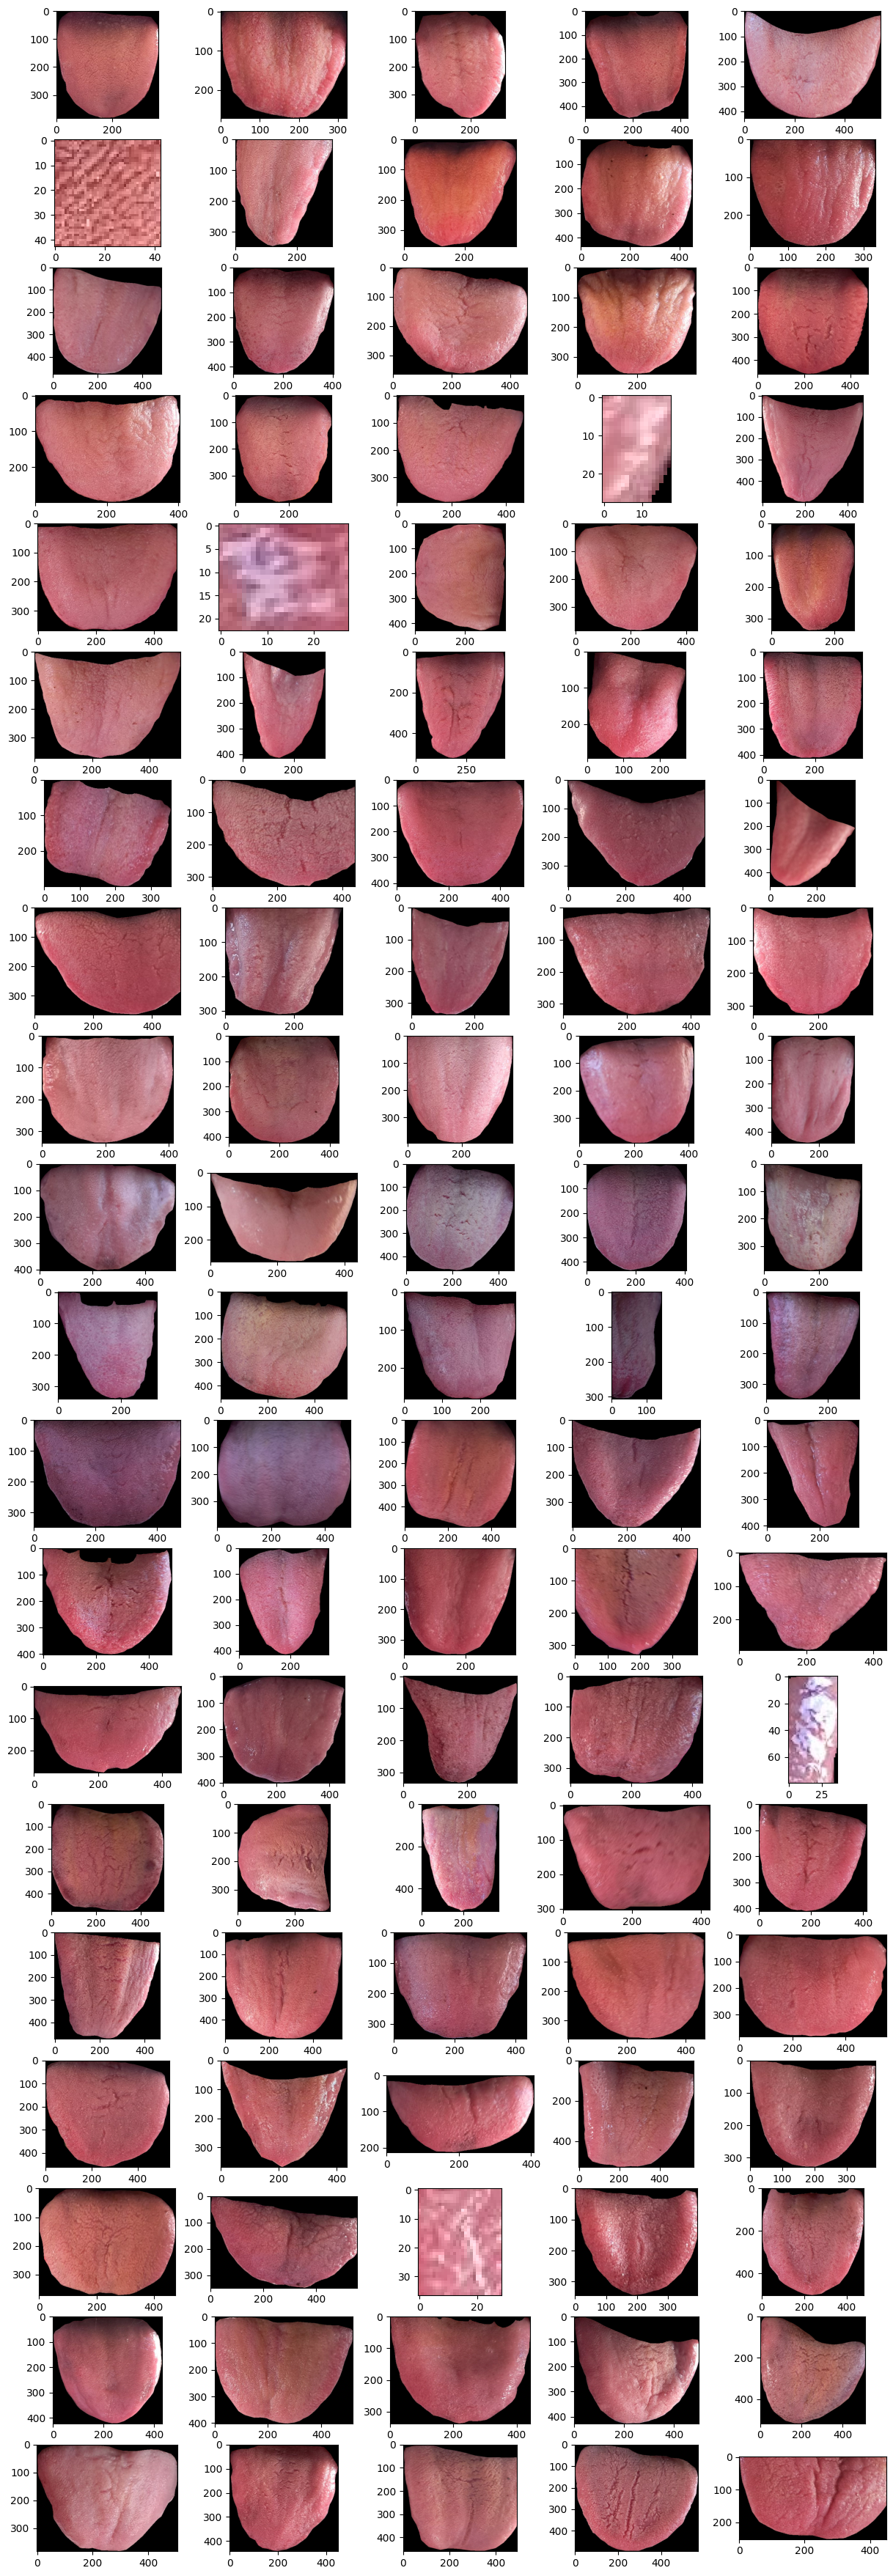

In [16]:
fig = plt.figure(figsize=(15, 45))
rows = 20
columns = 5

for i in range(1,101):

    fig.add_subplot(rows, columns, i)
    plt.imshow(cropped_img_folder[i-1][1]) 

# Proper 15 cutouts

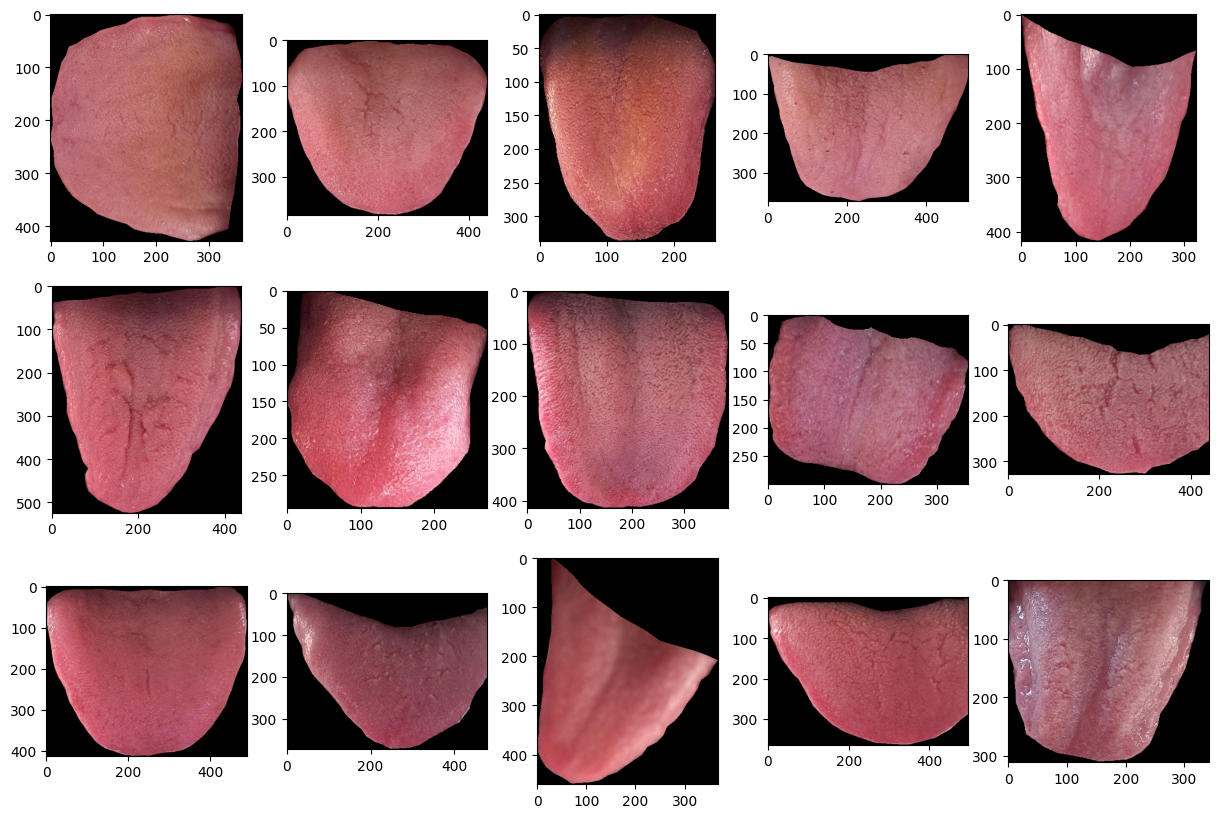

In [19]:
new_cutout = cropped_img_folder[22:37]

fig = plt.figure(figsize=(15, 10))
rows = 3
columns = 5

for i in range(1,16):

    fig.add_subplot(rows, columns, i)
    plt.imshow(new_cutout[i-1][1]) 

# Features

In [20]:
def resize(img,size):
    """size is a tuple"""
    """ returns resized images"""
    return cv2.resize(img,size)

def to_hsv(img):
    """return image in HSV space"""
    return cv2.cvtColor(img,cv2.COLOR_RGB2HSV)

def to_gray(img):
    """return image in gray space"""
    return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

def sum(arr):
    """returns sum and no. of pixels between 20 and 240"""
    sum = 0
    count = 0
    for i in arr:
        for j in i:
            if(j>20 and j<240): #only pixels whose value is between 20 and 240
                sum+=j
                count+=1

    return (sum,count)

def pooling(image, pool_size, code, padding):
    """
    different codes for different pooling
    code min :min pooling
    code max :max pooling 
    code mean :mean pooling 
    code std :standard deviation pooling
    returns a image with padding operation and pooling operation
    """

    padded = arr = np.zeros((image.shape[0] + padding*2, 
                       image.shape[1] + padding*2))
    
    #  inserting image into zero array
    padded[int(padding):-int(padding), int(padding):-int(padding)] = image
    
    
    # print(f'original image size: {image.shape}')
    # print(f'padded image size: {padded.shape}')

    input_height, input_width = padded.shape
    pool_height, pool_width = pool_size

    # Calculate the output dimensions
    output_height = input_height - pool_height + 1
    output_width = input_width - pool_width + 1

    # Initialize the output data
    output_data = np.zeros((output_height, output_width))

    for i in range(output_height):
        for j in range(output_width):
            # Extract the region of interest (ROI)
            roi = padded[i : i + pool_height, j : j + pool_width]
            
            if code=='min':
                # Apply min pooling within the ROI
                output_data[i, j] = np.min(roi)

            if code=='max':
                # Apply max pooling within the ROI
                output_data[i, j] = np.max(roi)

            if code=='mean':
                # Apply mean pooling within the ROI
                output_data[i, j] = np.mean(roi)

            if code=='std':
                # Apply min pooling within the ROI
                output_data[i, j] = np.std(roi)


    # print(f'{code} pooled image size: {output_data.shape}')
    return output_data

In [21]:
def feature(data):
    """Return all the 12 features as a numpy array"""
    uid,img,label = data
    img = resize(img,(250,250))

    #RGB SPACE
    r, g, b = cv2.split(img)
    sum_img = [sum(r),sum(g),sum(b),sum(r-g)]
    mean_features = [i[0]/i[1] for i in sum_img]
    mean_r,mean_g,mean_b,mean_rg = mean_features
    # 4 features done in RGB SPACE

    
    #HSV SPACE
    hsv = to_hsv(img)
    h,s,v = cv2.split(hsv)
    h = h/h.max()
    nH = np.count_nonzero(h>0.95)
    HHR = nH/h.size
    # HHR found

    
    #GRAY SPACE
    gray = to_gray(img)
    B_sum, B_size = sum(gray)
    B = B_sum/B_size # FOUND B

    #ENTROPY in gray space
    eq = cv2.equalizeHist(gray)
    unique, counts = np.unique(eq, return_counts=True)
    #only pixels whose value is between 20 and 240
    total_counts = counts[21:240].sum() 
    Ent = np.sum(np.array([-i*(i/total_counts)*math.log((i/total_counts),2) for i in counts[21:240]])) #Found Entropy

    #Calculating the 'G' features
    Ixy = gray
    min_Ixy = pooling(image=Ixy, pool_size=(3,3), code='min', padding=1)
    max_Ixy = pooling(image=Ixy, pool_size=(3,3), code='max', padding=1)
    mean_Ixy = pooling(image=Ixy, pool_size=(3,3), code='mean', padding=1)
    std_Ixy = pooling(image=Ixy, pool_size=(3,3), code='std', padding=1)
    
    g1 = Ixy - min_Ixy
    g2 = max_Ixy - Ixy
    g3 = Ixy - mean_Ixy
    g4 = std_Ixy
    g5 = Ixy
    
    G1 = g1.sum()/g1.size
    G2 = g2.sum()/g2.size
    G3 = g3.sum()/g3.size
    G4 = g4.sum()/g4.size
    G5 = g5.sum()/g5.size

    feature_all = [uid,mean_r,mean_g,mean_b,mean_rg,HHR,Ent,B,G1,G2,G3,G4,G5,label]
    return feature_all

# Dataset Creation

In [24]:
cutout_data = []
for i in range(len(new_cutout)):
    
    features = feature(new_cutout[i])
    cutout_data.append(features)

In [25]:
cols = ['number','mean_r','mean_g','mean_b','mean_rg','HHR','Ent','B','G1','G2','G3','G4','G5','label']

new_test_data = pd.DataFrame(cutout_data,columns=cols)

In [26]:
new_test_data.head(5)

number      mean_r      mean_g      mean_b    mean_rg       HHR  \
0  2024030528  171.455784   98.704465   99.405236  73.165402  0.395952   
1  2024030529  177.586420  100.488081  104.229500  77.436187  0.487472   
2  2024030530  158.952765   82.639954   80.032403  78.425968  0.261264   
3  2024030532  182.992063  111.660269  115.967909  71.704080  0.465408   
4  2024030533  188.234487  109.861433  124.905936  79.700378  0.589824   

           Ent           B        G1        G2        G3        G4         G5  \
0  5626.978912  120.476986  7.332560  7.597872  0.012869  4.936373  99.204832   
1  4123.362036  123.999087  7.805120  8.285408  0.022949  5.255326  95.633328   
2  3168.152038  104.774645  8.761504  9.060752  0.009632  5.740762  81.718416   
3  4089.694571  133.544508  8.234848  8.901456  0.024448  5.634071  94.260784   
4  4012.988397  135.312663  5.952512  6.380048  0.003563  4.141069  80.364128   

   label  
0   11.9  
1   12.4  
2   12.1  
3    7.0  
4    8.4

In [27]:
# new_test_data.to_csv('tongue_cutout_data.csv',index = False)